In [3]:
{
    "tags": [
        "hide-cell"
    ]
}


### Import standard libraries

import abc
from dataclasses import dataclass
import functools
import itertools

from typing import Any, Callable, NamedTuple, Optional, Union, Tuple

import matplotlib.pyplot as plt
import numpy as np


import jax
import jax.numpy as jnp
from jax import lax, vmap, jit, grad
from jax.scipy.special import logit
from jax.nn import softmax
from functools import partial
from jax.random import PRNGKey, split

import jsl
import ssm_jax


(sec:inference)=
# States estimation (inference)





Given the sequence of observations, and a known model,
one of the main tasks with SSMs
to perform posterior inference,
about the hidden states; this is also called
state estimation.
At each time step $t$,
there are multiple forms of posterior we may be interested in computing,
including the following:
- the filtering distribution
$p(\hidden_t|\obs_{1:t})$
- the smoothing distribution
$p(\hidden_t|\obs_{1:T})$ (note that this conditions on future data $T>t$)
- the fixed-lag smoothing distribution
$p(\hidden_{t-\ell}|\obs_{1:t})$ (note that this
infers $\ell$ steps in the past given data up to the present).

We may also want to compute the
predictive distribution $h$ steps into the future:
\begin{align}
p(\obs_{t+h}|\obs_{1:t})
= \sum_{\hidden_{t+h}} p(\obs_{t+h}|\hidden_{t+h}) p(\hidden_{t+h}|\obs_{1:t})
\end{align}
where the hidden state predictive distribution is
\begin{align}
p(\hidden_{t+h}|\obs_{1:t})
&= \sum_{\hidden_{t:t+h-1}}
 p(\hidden_t|\obs_{1:t}) 
 p(\hidden_{t+1}|\hidden_{t})
 p(\hidden_{t+2}|\hidden_{t+1})
\cdots
 p(\hidden_{t+h}|\hidden_{t+h-1})
\end{align}
See 
{numref}`fig:dbn-inference` for a summary of these distributions.

```{figure} /figures/inference-problems-tikz.png
:scale: 30%
:name: fig:dbn-inference

Illustration of the different kinds of inference in an SSM.
 The main kinds of inference for state-space models.
    The shaded region is the interval for which we have data.
    The arrow represents the time step at which we want to perform inference.
    $t$ is the current time,  $T$ is the sequence length,
$\ell$ is the lag and $h$ is the prediction horizon.
```

In addition  to comuting posterior marginals,
we may want to compute the most probable hidden sequence,
i.e., the joint MAP estimate
```{math}
\arg \max_{\hidden_{1:T}} p(\hidden_{1:T}|\obs_{1:T})
```
or sample sequences from the posterior
```{math}
\hidden_{1:T} \sim p(\hidden_{1:T}|\obs_{1:T})
```

Algorithms for all these task are discussed in the following chapters,
since the details depend on the form of the SSM.






(sec:casino-inference)=
## Example: inference in the casino HMM


We now illustrate filtering, smoothing and MAP decoding applied
to the casino HMM from {ref}`sec:casino` and [](sec:casino). 


In [4]:
# state transition matrix
A = np.array([
    [0.95, 0.05],
    [0.10, 0.90]
])

# observation matrix
B = np.array([
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6], # fair die
    [1/10, 1/10, 1/10, 1/10, 1/10, 5/10] # loaded die
])

pi = np.array([0.5, 0.5])

(nstates, nobs) = np.shape(B)

import distrax
from distrax import HMM


hmm = HMM(trans_dist=distrax.Categorical(probs=A),
            init_dist=distrax.Categorical(probs=pi),
            obs_dist=distrax.Categorical(probs=B))


seed = 314
n_samples = 300
z_hist, x_hist = hmm.sample(seed=PRNGKey(seed), seq_len=n_samples)


[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0
 0 0 0 0]
[5 2 2 5 5 4 2 3 1 5 4 1 2 4 2 5 0 5 3 3 3 1 2 5 3 0 1 2 2 0 2 4 0 1 3 5 5
 4 0 5 0 2 2 1 4 0 5 0 5 4 5 2 5 5 1 3 5 1 3 1 1 2 5 2 1 0 3 5 3 0 2 0 4 2
 5 1 3 4 3 5 5 5 1 2 3 5 4 0 3 4 1 5 2 4 5 4 2 5 4 0 2 5 1 0 4 0 2 2 1 4 1
 1 1 1 2 5 0 3 1 2 2 1 2 4 3 0 3 0 0 5 5 0 0 5 1 4 3 1 5 5 5 0 2 1 2 3 5 5
 5 1 2 2 5 5 0 4 2 5 1 5 5 4 1 5 2 4 5 3 0 1 2 2 4 1 1 3 5 5 4 5 2 5 5 3 0
 3 4 1 4 2 4 2 

In [5]:
# Call inference engine

filtered_dist, _, smoothed_dist, loglik = hmm.forward_backward(x_hist)
map_path = hmm.viterbi(x_hist)

/opt/anaconda3/envs/spyder-dev/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [6]:
# Find the span of timesteps that the    simulated systems turns to be in state 1
def find_dishonest_intervals(z_hist):
    spans = []
    x_init = 0
    for t, _ in enumerate(z_hist[:-1]):
        if z_hist[t + 1] == 0 and z_hist[t] == 1:
            x_end = t
            spans.append((x_init, x_end))
        elif z_hist[t + 1] == 1 and z_hist[t] == 0:
            x_init = t + 1
    return spans

In [7]:
# Plot posterior
def plot_inference(inference_values, z_hist, ax, state=1, map_estimate=False):
    n_samples = len(inference_values)
    xspan = np.arange(1, n_samples + 1)
    spans = find_dishonest_intervals(z_hist)
    if map_estimate:
        ax.step(xspan, inference_values, where="post")
    else:
        ax.plot(xspan, inference_values[:, state])

    for span in spans:
        ax.axvspan(*span, alpha=0.5, facecolor="tab:gray", edgecolor="none")
    ax.set_xlim(1, n_samples)
    # ax.set_ylim(0, 1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Observation number")

Text(0.5, 1.0, 'Filtered')

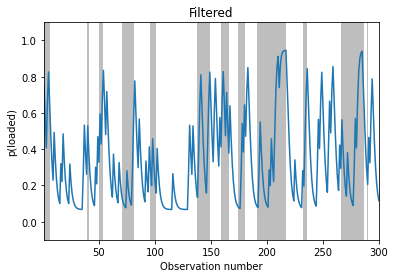

In [8]:
 # Filtering
fig, ax = plt.subplots()
plot_inference(filtered_dist, z_hist, ax)
ax.set_ylabel("p(loaded)")
ax.set_title("Filtered")
 

  

Text(0.5, 1.0, 'Smoothed')

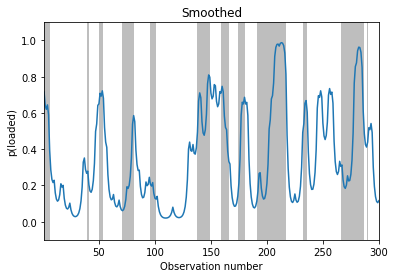

In [9]:
# Smoothing
fig, ax = plt.subplots()
plot_inference(smoothed_dist, z_hist, ax)
ax.set_ylabel("p(loaded)")
ax.set_title("Smoothed")


 

Text(0.5, 1.0, 'Viterbi')

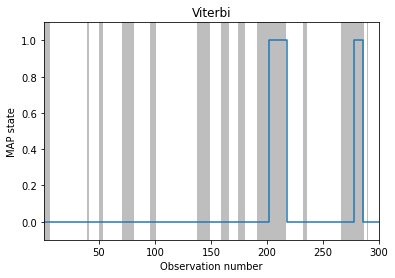

In [10]:
# MAP estimation
fig, ax = plt.subplots()
plot_inference(map_path, z_hist, ax, map_estimate=True)
ax.set_ylabel("MAP state")
ax.set_title("Viterbi")


In [ ]:
# TODO: posterior samples


## Example: inference in the tracking LG-SSM

We now illustrate filtering, smoothing and MAP decoding applied
to the 2d tracking HMM from {ref}`sec:tracking-lds`. 

In [4]:
key = jax.random.PRNGKey(314)
timesteps = 15
delta = 1.0
A = jnp.array([
    [1, 0, delta, 0],
    [0, 1, 0, delta],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = A.shape
observation_size, _ = C.shape

Q = jnp.eye(state_size) * 0.001
R = jnp.eye(observation_size) * 1.0
mu0 = jnp.array([8, 10, 1, 0]).astype(float)
Sigma0 = jnp.eye(state_size) * 1.0

from jsl.lds.kalman_filter import LDS, smooth, filter

lds = LDS(A, C, Q, R, mu0, Sigma0)


z_hist, x_hist = lds.sample(key, timesteps)



In [5]:
from jsl.demos.plot_utils import plot_ellipse

def plot_tracking_values(observed, filtered, cov_hist, signal_label, ax):
    timesteps, _ = observed.shape
    ax.plot(observed[:, 0], observed[:, 1], marker="o", linewidth=0,
            markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
    ax.plot(*filtered[:, :2].T, label=signal_label, c="tab:red", marker="x", linewidth=2)
    for t in range(0, timesteps, 1):
        covn = cov_hist[t][:2, :2]
        plot_ellipse(covn, filtered[t, :2], ax, n_std=2.0, plot_center=False)
    ax.axis("equal")
    ax.legend()

L2-filter: 3.2481


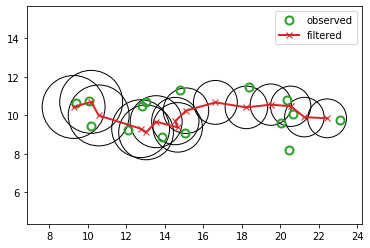

In [6]:
# Filtering

mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist = filter(lds, x_hist)
l2_filter = jnp.linalg.norm(z_hist[:, :2] - mu_hist[:, :2], 2)
print(f"L2-filter: {l2_filter:0.4f}")
fig_filtered, axs = plt.subplots()
plot_tracking_values(x_hist, mu_hist, Sigma_hist, "filtered", axs)

L2-smooth: 2.0450


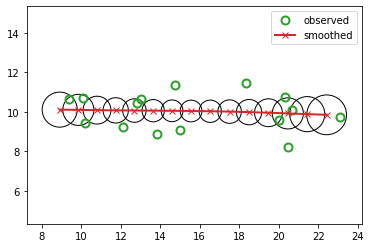

In [7]:
# Smoothing

mu_hist_smooth, Sigma_hist_smooth = smooth(lds, mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist)
l2_smooth = jnp.linalg.norm(z_hist[:, :2] - mu_hist_smooth[:, :2], 2)
print(f"L2-smooth: {l2_smooth:0.4f}")
fig_smoothed, axs = plt.subplots()
plot_tracking_values(x_hist, mu_hist_smooth, Sigma_hist_smooth, "smoothed", axs)